# Customer Clustering Analysis

## Project Overview
This analysis aims to group customers using clustering algorithms, identify characteristics and behavior patterns of different customer segments, and provide data-driven insights for sales and marketing strategies. 

Through these analyses, we can:
- Identify high-value customer segments
- Discover potential growth opportunities
- Optimize customer management strategies
- Improve customer retention rates and satisfaction

The results will help the sales team develop more targeted customer strategies, increase sales efficiency, and enhance customer value.

Note: This is based on simulated sales records. It does not 100% replicate the original data distribution.


## Data Preprocessing

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
from datetime import datetime, timedelta
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

In [3]:
# Data loading
df = pd.read_csv('sales_order_simulated_v13.csv')
df.info()
df.drop(columns=['Current_Rep'], inplace=True)
print(f"Dataset shape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Current_Rep      15000 non-null  object 
 1   Seller           15000 non-null  object 
 2   Date             15000 non-null  object 
 3   Doc_Type         15000 non-null  object 
 4   Doc_No           15000 non-null  object 
 5   Customer         15000 non-null  object 
 6   Customer_Group   15000 non-null  object 
 7   Material_Code    15000 non-null  object 
 8   Amount           15000 non-null  float64
 9   Sales_Qty        15000 non-null  int64  
 10  Ship_To_State    10415 non-null  object 
 11  Billing_Country  15000 non-null  object 
 12  Material_Name    15000 non-null  object 
 13  Broad_Phase      15000 non-null  object 
 14  Product_Phase    15000 non-null  object 
 15  Particle_size    15000 non-null  object 
 16  Pore_size        15000 non-null  object 
 17  ID_(mm)     

In [4]:
# Data preprocessing

df['Date'] = pd.to_datetime(df['Date'])  # Convert Date to datetime
df = df[df['Date'] >= '2022-01-01'].sort_values(by='Date').reset_index(drop=True).copy()  # Filter data from 2022 onwards
df = df[df['Amount'] > 0]  # Filter out negative amounts
df['quarter'] = df['Date'].dt.to_period('Q') # Add quarter column

# Display sample of processed data
df.head()

,Seller,Date,Doc_Type,Doc_No,Customer,Customer_Group,Material_Code,Amount,Sales_Qty,Ship_To_State,...,Broad_Phase,Product_Phase,Particle_size,Pore_size,ID_(mm),Length_(mm),List_price,Price_Floor,Specification,quarter
0,Sales Rep D,2022-01-01,Standard Sales Order,SO2024003385,ACCT_0827_WZZ,ACCT_0827,FAKE-00340,1611.61,1,MA,...,RP,Bio-C4,5,300,4.6,150,1334.21,961.03,4.6mmx150mm,2022Q1
1,Sales Rep D,2022-01-01,Standard Sales Order,SO2023000939,ACCT_0561_QSC,ACCT_0561,FAKE-01173,3576.50,10,IN,...,SEC,SRT-C SEC,5,100,4.6,50,370.16,305.56,4.6mmx50mm,2022Q1
2,Sales Rep D,2022-01-01,Standard Sales Order,SO2023000867,ACCT_0477_UFK,ACCT_0477,FAKE-00515,10238.80,4,CA,...,SEC,Zenix SEC,3,300,4.6,300,1969.00,1772.10,4.6mmx300mm,2022Q1
3,Sales Rep D,2022-01-01,Standard Sales Order,SO2024005221,ACCT_0549_QEM,ACCT_0549,FAKE-00037,131.90,1,CA,...,Accessories,Coupler,Null,Null,Null,Null,110.00,93.50,Null,2022Q1
4,Sales Rep A,2022-01-01,Standard Sales Order,SO2025014084,ACCT_1048_UAH,ACCT_1048,FAKE-00170,1554.32,4,CA,...,RP,Bio-C8,5,300,4.6,250,434.83,380.55,4.6mmx250mm,2022Q1


## Sales Rep Assignment

Sales territory changes over time, but we don't modify historical data at the source.
Instead, we update the assigned sales representatives based on current territory assignments.
This ensures data consistency while reflecting current organizational structure.



In [5]:
# Sales rep assignment based on regions and territories
print("Available columns:", df.columns.tolist())

# Define the sales rep assignments based on regions and territories
# USA States - 4 sales reps for US territories  
usa_state_mapping = {
    'Sales Rep A': ['ME', 'VT', 'NH', 'MA', 'RI', 'CT'],
    'Sales Rep B': ['NY', 'NJ', 'PA', 'DE', 'MD', 'DC', 'VA', 'WV'],
    'Sales Rep C': ['NC', 'SC', 'GA', 'FL','MS', 'AL'],
    'Sales Rep D': ['ND', 'SD', 'NE', 'KS', 'OK', 'TX'],
    'Sales Rep E': ['WA', 'OR', 'CA', 'NV', 'AK', 'HI'],
    'Sales Rep F': ['ID', 'MT', 'WY', 'UT', 'CO', 'AZ', 'NM'],
    'Sales Rep G': ['MN', 'IA', 'MO', 'AR', 'LA', 'WI', 'IL', 'MI', 'IN', 'OH', 'KY', 'TN'],
}

# Regional assignments for the actual countries in the dataset
regional_assignments = {
    # Asia-Pacific
    'Sales Rep A': ['China', 'Japan'],

    'Sales Rep B': ['Singapore', 'South Korea'],
    
    # Europe  
    'Sales Rep C': ['France', 'Netherlands', 'Spain', 'UK'],

    'Sales Rep D': ['Germany'],

    'Sales Rep E': ['Italy'],
    
    # Canada
    'Sales Rep F': ['Canada'],
}

# Combine all mappings into one comprehensive dictionary
all_territory_mapping = {}

# Add USA states
for rep, states in usa_state_mapping.items():
    for state in states:
        all_territory_mapping[state] = rep

# Add regional assignments
for rep, countries in regional_assignments.items():
    for country in countries:
        all_territory_mapping[country] = rep

# High-performance vectorized sales rep assignment
# STEP 1: Initialize with default assignment
df['Assigned_Rep'] = 'Sales Rep H'  # Default for Rest of World

# STEP 2: Apply country mappings for international countries (vectorized)
country_mapping = {}
for rep, countries in regional_assignments.items():
    for country in countries:
        country_mapping[country] = rep

# Apply country mappings (vectorized)
df.loc[df['Billing_Country'].notna(), 'Assigned_Rep'] = df.loc[df['Billing_Country'].notna(), 'Billing_Country'].map(country_mapping).fillna(df.loc[df['Billing_Country'].notna(), 'Assigned_Rep'])

# STEP 3: USA state assignments (vectorized)
usa_mask = (df['Billing_Country'] == 'USA') & df['Ship_To_State'].notna()
df.loc[usa_mask, 'Assigned_Rep'] = df.loc[usa_mask, 'Ship_To_State'].map(all_territory_mapping).fillna('Unknown - USA (No State)')

# Handle USA without state info
usa_no_state_mask = (df['Billing_Country'] == 'USA') & df['Ship_To_State'].isna()
df.loc[usa_no_state_mask, 'Assigned_Rep'] = 'Unknown - USA (No State)'

# Show assignment summary
print("\nSales rep assignment summary:")
print(df['Assigned_Rep'].value_counts())

# Sales rep and territory summary check
print("\n📊 SALES REP & TERRITORY SUMMARY:")
print("=" * 60)

for rep in sorted(df['Assigned_Rep'].unique()):
    rep_data = df[df['Assigned_Rep'] == rep]
    
    print(f"\n{rep}:")
    print(f"  Total records: {len(rep_data)}")
    
    # Country breakdown
    country_counts = rep_data['Billing_Country'].value_counts()
    countries = country_counts.index.tolist()  # Define countries variable
    print(f"  Countries covered: {len(country_counts)} total")
    for country, count in country_counts.head(5).items():
        percentage = (count / len(rep_data)) * 100
        print(f"    • {country}: {count} records ({percentage:.1f}%)")
    
    # Show USA states if applicable
    if 'USA' in country_counts:
        usa_states = rep_data[rep_data['Billing_Country'] == 'USA']['Ship_To_State'].value_counts()
        print(f"    USA States: {len(usa_states)} total")
        if not usa_states.empty:
            print(f"    Top USA states: {', '.join(usa_states.head(5).index.tolist())}")
    
    # Show Canada provinces if applicable
    if 'Canada' in countries:
        canada_provinces = rep_data[rep_data['Billing_Country'] == 'Canada']['Ship_To_State'].value_counts()
        print(f"    Canada Provinces: {len(canada_provinces)} total")
        if not canada_provinces.empty:
            print(f"    Canada provinces: {', '.join(canada_provinces.head(5).index.tolist())}")


Available columns: ['Seller', 'Date', 'Doc_Type', 'Doc_No', 'Customer', 'Customer_Group', 'Material_Code', 'Amount', 'Sales_Qty', 'Ship_To_State', 'Billing_Country', 'Material_Name', 'Broad_Phase', 'Product_Phase', 'Particle_size', 'Pore_size', 'ID_(mm)', 'Length_(mm)', 'List_price', 'Price_Floor', 'Specification', 'quarter']

Sales rep assignment summary:
Assigned_Rep
Sales Rep E                 3858
Sales Rep A                 2532
Sales Rep B                 2513
Sales Rep H                 2429
Sales Rep G                 1407
Sales Rep D                  950
Sales Rep C                  929
Sales Rep F                  358
Unknown - USA (No State)      24
Name: count, dtype: int64

📊 SALES REP & TERRITORY SUMMARY:

Sales Rep A:
  Total records: 2532
  Countries covered: 3 total
    • USA: 2287 records (90.3%)
    • Japan: 233 records (9.2%)
    • China: 12 records (0.5%)
    USA States: 6 total
    Top USA states: MA, CT, ME, NH, RI

Sales Rep B:
  Total records: 2513
  Countries 

## Customer Feature Engineering
Customer Feature Engineering for Clustering Analysis
 
This section creates customer features for machine learning clustering:
 
**Core RFM Features:**
- **Recency**: Days since last purchase (log-transformed)
- **Frequency**: Number of unique quarters with purchases
- **Monetary**: Total revenue and average order value (log-transformed)

**Business Intelligence Features:**
- **Customer Lifetime**: Total quarters from first to last purchase
- **Product Diversity**: Number of unique materials purchased
- **Geographic Segmentation**: Billing country for regional analysis
- **Churn Risk**: Binary indicator for customers inactive >365 days
- **Big Order Behavior**: Analysis of large transaction patterns

**Technical Approach:**
- Log transformation for skewed monetary/recency distributions
- Quarterly aggregation for seasonal business patterns
- Territory assignment integration for sales rep accountability

These engineered features enable sophisticated customer segmentation for:
- Sales territory optimization
- Customer retention strategies  
- Revenue forecasting
- Personalized marketing campaigns


In [6]:
# Customer information

df = df[df['Assigned_Rep'] != 'Unknown - USA (No State)'].reset_index(drop=True)  # Filter out records with unassgined rep

customer_df = df.groupby('Customer_Group').agg({     # Grouping by Customer_Group and aggregating the data
    'Assigned_Rep': 'first',
    'Amount': 'sum',
    'Doc_No': 'nunique',
    'Billing_Country': 'first',
    'Date': 'max',
    'quarter': 'nunique',
    'Material_Name': 'nunique'
}).reset_index()

customer_df.columns = ['customer_group', 'assigned_rep', 'monetary', 'doc_no_unique', 'billing_country', 'last_purchase_date', 'frequency_q', 'material_name_unique']  # Renaming the columns

customer_df['recency'] = (pd.to_datetime('now') - customer_df['last_purchase_date']).dt.days  # Calculating the recency
customer_df['monetary_avg'] = (customer_df['monetary'] / customer_df['doc_no_unique']).round(2)  # Calculating the monetary average
customer_df['churn'] = (customer_df['recency'] > 365).astype(int)  # Calculating the churn

# Move Monetary column after Assigned_Rep using insert() + pop() method
customer_df.insert(6, 'monetary', customer_df.pop('monetary'))  # Moving the Monetary column after Assigned_Rep

# Transforming part
customer_df['log_monetary'] = np.log1p(customer_df['monetary'])  # Transforming the Monetary column to log scale
customer_df['log_recency'] = np.log1p(customer_df['recency'])  # Transforming the Recency column to log scale

# Calculate total quarters since first purchase
first_purchase = df.groupby('Customer_Group')['Date'].min().reset_index()
first_purchase.columns = ['customer_group', 'first_purchase_date']

# Merge with customer_df
customer_df = customer_df.merge(first_purchase, on='customer_group', how='left')

# Calculate total quarters from first purchase to last purchase
# Convert dates to quarter periods
customer_df['last_q'] = pd.to_datetime('now').to_period('Q')
customer_df['first_q'] = customer_df['first_purchase_date'].dt.to_period('Q')

# Calculate difference in quarters and convert to integer
customer_df['life_time'] = (customer_df['last_q'].astype('int64') - customer_df['first_q'].astype('int64'))+1


# Calculate big orders
big_orders = df.groupby('Doc_No').agg({
    'Amount': 'sum',
    'Customer_Group': 'first'
}).reset_index()
big_orders = big_orders[big_orders['Amount'] >= 8000]


big_order_count = big_orders.groupby('Customer_Group').size().reset_index(name='big_order_count')

customer_df = customer_df.merge(big_order_count, left_on='customer_group', right_on='Customer_Group', how='left')

customer_df['big_order_count'] = customer_df['big_order_count'].fillna(0).astype(int)

customer_df.drop(columns=['Customer_Group'], inplace=True)



# Calculate days since last purchase
today = datetime.now()
#active_customers['last_purchase_date'] = pd.to_datetime(active_customers['last_purchase_date'])
customer_df['days_since_first_purchase'] = (today - customer_df['first_purchase_date']).dt.days

# Define customer status: if churn = 1, then status = 'Churn', otherwise categorize by recency
customer_df['customer_status'] = np.where(customer_df['churn'] == 1, 'Churn',
                                         np.where(customer_df['days_since_first_purchase'] <= 90, 'New', 'Existing'))


customer_df

,customer_group,assigned_rep,doc_no_unique,billing_country,last_purchase_date,frequency_q,monetary,material_name_unique,recency,monetary_avg,churn,log_monetary,log_recency,first_purchase_date,last_q,first_q,life_time,big_order_count,days_since_first_purchase,customer_status
0,ACCT_0001,Sales Rep H,15,Switzerland,2025-07-13,7,51687.68,15,71,3445.85,0,10.852994,4.276666,2023-10-13,2025Q3,2023Q4,8,2,710,Existing
1,ACCT_0002,Sales Rep A,6,USA,2025-07-28,3,15094.03,6,56,2515.67,0,9.622121,4.043051,2024-10-22,2025Q3,2024Q4,4,0,335,Existing
2,ACCT_0003,Sales Rep A,4,USA,2025-07-19,4,14780.37,4,65,3695.09,0,9.601123,4.189655,2024-11-29,2025Q3,2024Q4,4,1,297,Existing
3,ACCT_0004,Sales Rep B,33,USA,2024-06-14,9,114949.16,27,465,3483.31,1,11.652254,6.144186,2022-01-24,2025Q3,2022Q1,15,4,1337,Churn
4,ACCT_0005,Sales Rep H,4,Belgium,2025-03-10,4,5059.60,4,196,1264.90,0,8.529240,5.283204,2024-03-26,2025Q3,2024Q1,7,0,545,Existing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,ACCT_1196,Sales Rep E,8,USA,2025-08-30,4,18806.96,6,23,2350.87,0,9.842035,3.178054,2024-09-24,2025Q3,2024Q3,5,0,363,Existing
1196,ACCT_1197,Sales Rep C,5,USA,2024-06-27,4,8765.89,5,452,1753.18,1,9.078737,6.115892,2023-04-20,2025Q3,2023Q2,10,0,886,Churn
1197,ACCT_1198,Sales Rep E,8,USA,2025-05-23,6,19734.00,8,122,2466.75,0,9.890149,4.812184,2023-01-21,2025Q3,2023Q1,11,0,975,Existing
1198,ACCT_1199,Sales Rep B,3,USA,2023-06-11,3,18966.07,2,834,6322.02,1,9.850460,6.727432,2022-04-11,2025Q3,2022Q2,14,1,1260,Churn


In [7]:
# Adding Broad_Phase information to customer_df
broad_phase_info = df[['Customer_Group', 'Broad_Phase']].dropna()

# Merging Broad_Phase information to customer_df
customer_df_with_broad_phase = customer_df.merge(
    broad_phase_info, 
    left_on='customer_group', 
    right_on='Customer_Group', 
    how='left'
)

# Counting unique orders for each customer group in each Broad_Phase using unstack
df_filtered = df[df['Customer_Group'].isin(customer_df['customer_group'])]
pivot_table = df_filtered.groupby(['Customer_Group', 'Broad_Phase'])['Doc_No'].nunique().unstack(fill_value=0)

# Checking the total count of Broad_Phase columns
print("Total count of Broad_Phase unique orders:")
print(pivot_table.sum().sort_values(ascending=False))
print("\n")


# Keeping columns with total count greater than 100
columns_to_keep = pivot_table.columns[pivot_table.sum() >= 100]
pivot_table_filtered = pivot_table[columns_to_keep]

print("Broad_Phase columns after filtering:")
print(pivot_table_filtered.sum().sort_values(ascending=False))

# Assigning the filtered table to pivot_table
pivot_table = pivot_table_filtered


Total count of Broad_Phase unique orders:
Broad_Phase
SEC                       8046
IEX                       1634
RP                        1246
Accessories                877
HIC                        875
Service                    554
Sepax Protein Standard     436
Carbomix                   412
Tween                      268
Affinity                   173
FPLC Empty Column           93
NP                          82
Bulk                        82
Null                        72
Packing Service             49
Mixed Mode                  44
HILIC                       33
dtype: int64


Broad_Phase columns after filtering:
Broad_Phase
SEC                       8046
IEX                       1634
RP                        1246
Accessories                877
HIC                        875
Service                    554
Sepax Protein Standard     436
Carbomix                   412
Tween                      268
Affinity                   173
dtype: int64


In [8]:
pivot_table

Broad_Phase,Accessories,Affinity,Carbomix,HIC,IEX,RP,SEC,Sepax Protein Standard,Service,Tween
Customer_Group,,,,,,,,,,
ACCT_0001,0,0,1,1,1,0,10,1,0,1
ACCT_0002,1,0,0,0,2,1,2,0,0,0
ACCT_0003,0,0,0,0,1,1,2,0,0,0
ACCT_0004,2,1,2,3,5,3,15,1,1,0
ACCT_0005,0,0,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
ACCT_1196,0,0,0,2,1,1,3,1,0,0
ACCT_1197,0,0,0,0,2,1,1,1,0,0
ACCT_1198,1,0,0,1,1,0,4,0,0,0


In [9]:
# Add Broad_Phase information to customer_df
customer_df = customer_df.merge(pivot_table, left_on='customer_group', right_index=True, how='left')
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_group             1200 non-null   object        
 1   assigned_rep               1200 non-null   object        
 2   doc_no_unique              1200 non-null   int64         
 3   billing_country            1200 non-null   object        
 4   last_purchase_date         1200 non-null   datetime64[ns]
 5   frequency_q                1200 non-null   int64         
 6   monetary                   1200 non-null   float64       
 7   material_name_unique       1200 non-null   int64         
 8   recency                    1200 non-null   int64         
 9   monetary_avg               1200 non-null   float64       
 10  churn                      1200 non-null   int32         
 11  log_monetary               1200 non-null   float64       
 12  log_re

In [10]:
customer_df['churn'].value_counts()  # here 0 means not churned, 1 means churned

churn
0    713
1    487
Name: count, dtype: int64

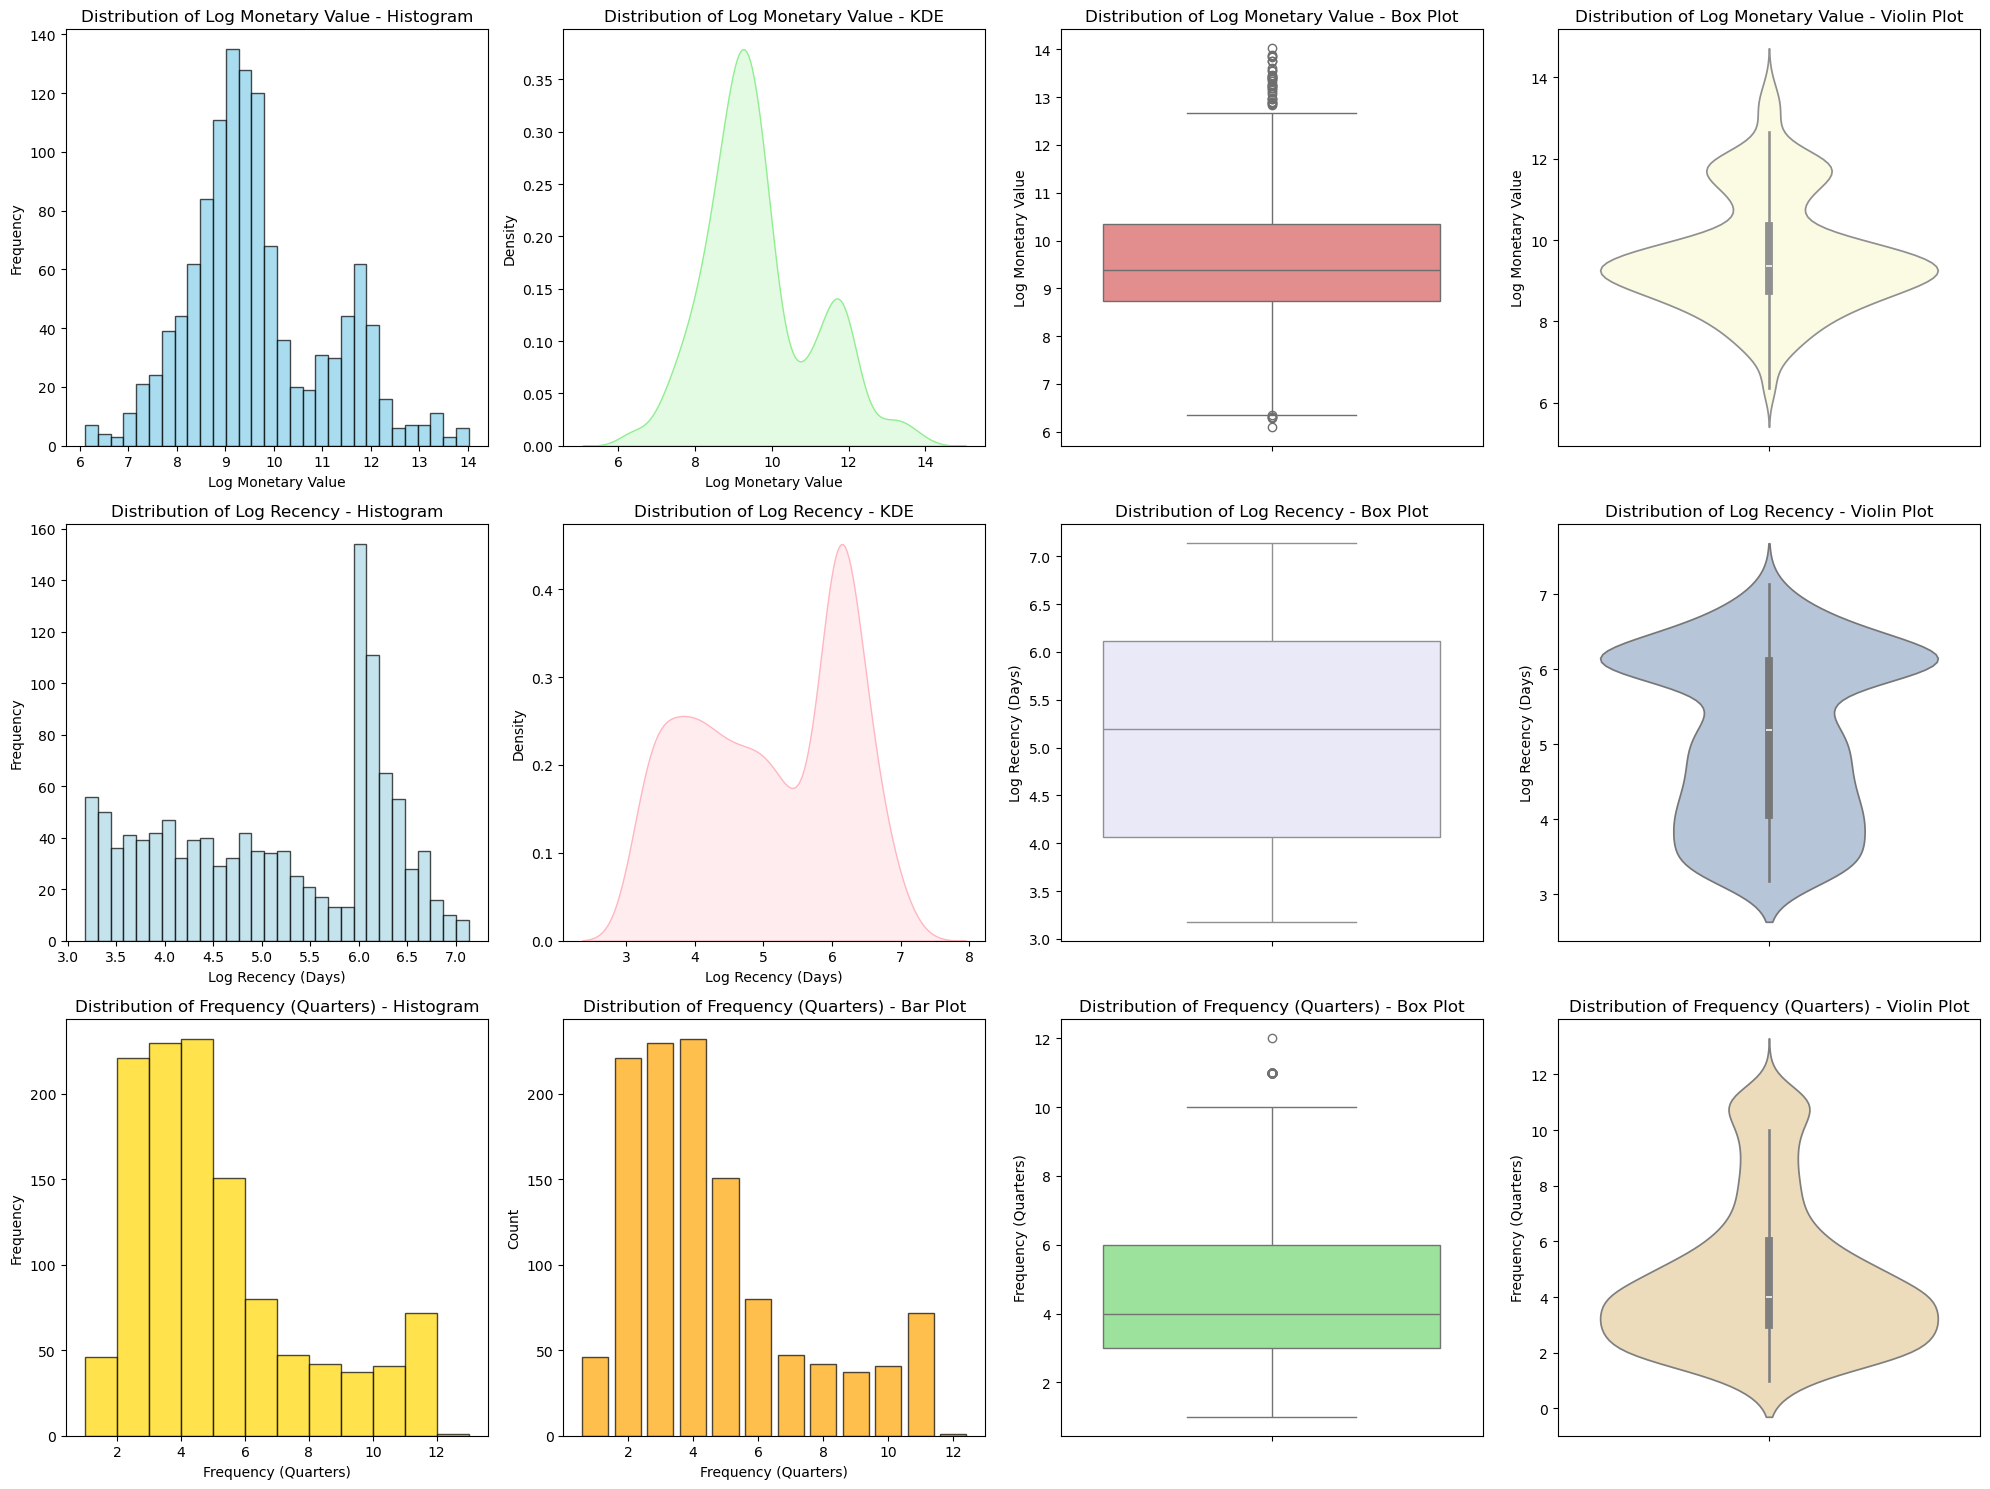

BASIC STATISTICS

Log Monetary Value:
Mean: 9.65
Median: 9.37
Standard Deviation: 1.43
Minimum: 6.10
Maximum: 14.02

Log Recency (Days):
Mean: 5.11
Median: 5.19
Standard Deviation: 1.12
Minimum: 3.18
Maximum: 7.14

Frequency (Quarters):
Mean: 4.63
Median: 4.00
Standard Deviation: 2.68
Minimum: 1
Maximum: 12
Mode: 4


In [11]:
# Visualization of RFM variables

# Create distribution plots for log_monetary, log_recency, and frequency_q
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# ===== LOG MONETARY =====
# 1. Histogram with KDE
axes[0, 0].hist(customer_df['log_monetary'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Log Monetary Value - Histogram')
axes[0, 0].set_xlabel('Log Monetary Value')
axes[0, 0].set_ylabel('Frequency')

# 2. KDE plot
sns.kdeplot(data=customer_df, x='log_monetary', ax=axes[0, 1], fill=True, color='lightgreen')
axes[0, 1].set_title('Distribution of Log Monetary Value - KDE')
axes[0, 1].set_xlabel('Log Monetary Value')
axes[0, 1].set_ylabel('Density')

# 3. Box plot
sns.boxplot(data=customer_df, y='log_monetary', ax=axes[0, 2], color='lightcoral')
axes[0, 2].set_title('Distribution of Log Monetary Value - Box Plot')
axes[0, 2].set_ylabel('Log Monetary Value')

# 4. Violin plot
sns.violinplot(data=customer_df, y='log_monetary', ax=axes[0, 3], color='lightyellow')
axes[0, 3].set_title('Distribution of Log Monetary Value - Violin Plot')
axes[0, 3].set_ylabel('Log Monetary Value')

# ===== LOG RECENCY =====
# 1. Histogram with KDE
axes[1, 0].hist(customer_df['log_recency'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[1, 0].set_title('Distribution of Log Recency - Histogram')
axes[1, 0].set_xlabel('Log Recency (Days)')
axes[1, 0].set_ylabel('Frequency')

# 2. KDE plot
sns.kdeplot(data=customer_df, x='log_recency', ax=axes[1, 1], fill=True, color='lightpink')
axes[1, 1].set_title('Distribution of Log Recency - KDE')
axes[1, 1].set_xlabel('Log Recency (Days)')
axes[1, 1].set_ylabel('Density')

# 3. Box plot
sns.boxplot(data=customer_df, y='log_recency', ax=axes[1, 2], color='lavender')
axes[1, 2].set_title('Distribution of Log Recency - Box Plot')
axes[1, 2].set_ylabel('Log Recency (Days)')

# 4. Violin plot
sns.violinplot(data=customer_df, y='log_recency', ax=axes[1, 3], color='lightsteelblue')
axes[1, 3].set_title('Distribution of Log Recency - Violin Plot')
axes[1, 3].set_ylabel('Log Recency (Days)')

# ===== FREQUENCY_Q =====
# 1. Histogram
axes[2, 0].hist(customer_df['frequency_q'], bins=range(1, customer_df['frequency_q'].max()+2), alpha=0.7, color='gold', edgecolor='black')
axes[2, 0].set_title('Distribution of Frequency (Quarters) - Histogram')
axes[2, 0].set_xlabel('Frequency (Quarters)')
axes[2, 0].set_ylabel('Frequency')

# 2. Bar plot (since frequency_q is discrete)
frequency_counts = customer_df['frequency_q'].value_counts().sort_index()
axes[2, 1].bar(frequency_counts.index, frequency_counts.values, alpha=0.7, color='orange', edgecolor='black')
axes[2, 1].set_title('Distribution of Frequency (Quarters) - Bar Plot')
axes[2, 1].set_xlabel('Frequency (Quarters)')
axes[2, 1].set_ylabel('Count')

# 3. Box plot
sns.boxplot(data=customer_df, y='frequency_q', ax=axes[2, 2], color='lightgreen')
axes[2, 2].set_title('Distribution of Frequency (Quarters) - Box Plot')
axes[2, 2].set_ylabel('Frequency (Quarters)')

# 4. Violin plot
sns.violinplot(data=customer_df, y='frequency_q', ax=axes[2, 3], color='wheat')
axes[2, 3].set_title('Distribution of Frequency (Quarters) - Violin Plot')
axes[2, 3].set_ylabel('Frequency (Quarters)')

plt.tight_layout()
plt.show()

# Print basic statistics for all three variables
print("="*60)
print("BASIC STATISTICS")
print("="*60)

print("\nLog Monetary Value:")
print(f"Mean: {customer_df['log_monetary'].mean():.2f}")
print(f"Median: {customer_df['log_monetary'].median():.2f}")
print(f"Standard Deviation: {customer_df['log_monetary'].std():.2f}")
print(f"Minimum: {customer_df['log_monetary'].min():.2f}")
print(f"Maximum: {customer_df['log_monetary'].max():.2f}")

print("\nLog Recency (Days):")
print(f"Mean: {customer_df['log_recency'].mean():.2f}")
print(f"Median: {customer_df['log_recency'].median():.2f}")
print(f"Standard Deviation: {customer_df['log_recency'].std():.2f}")
print(f"Minimum: {customer_df['log_recency'].min():.2f}")
print(f"Maximum: {customer_df['log_recency'].max():.2f}")

print("\nFrequency (Quarters):")
print(f"Mean: {customer_df['frequency_q'].mean():.2f}")
print(f"Median: {customer_df['frequency_q'].median():.2f}")
print(f"Standard Deviation: {customer_df['frequency_q'].std():.2f}")
print(f"Minimum: {customer_df['frequency_q'].min()}")
print(f"Maximum: {customer_df['frequency_q'].max()}")
print(f"Mode: {customer_df['frequency_q'].mode().iloc[0]}")


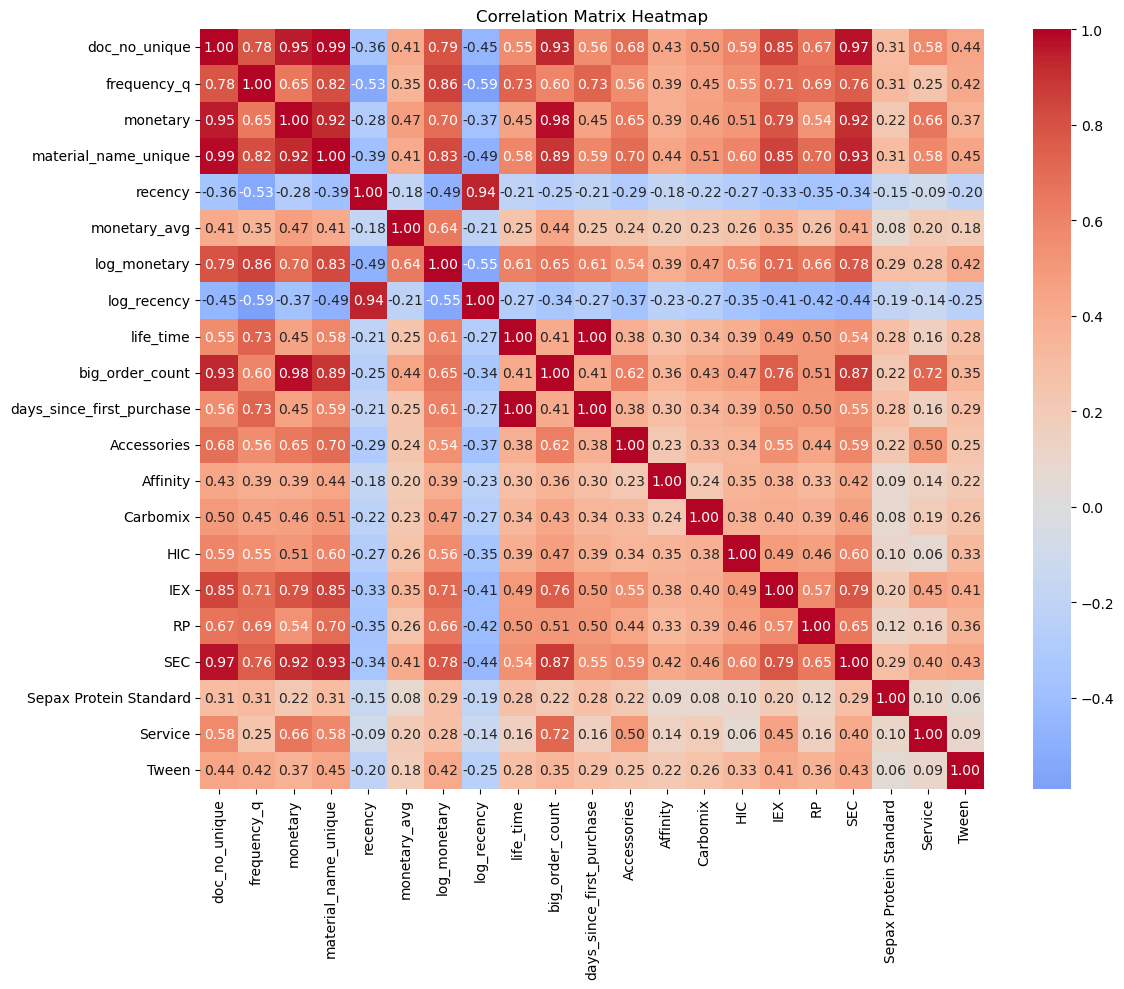

In [12]:
# Feature correlation
active_customers = customer_df[customer_df['churn']==0]
num_df = active_customers.select_dtypes(include=['int', 'float']).drop(columns=['churn'])
num_df.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()



## Customer Clustering with PCA
In this section, we apply Principal Component Analysis (PCA) for dimensionality reduction and then perform K-means clustering to segment customers based on their behavior patterns.


### Feature Selection and Standardization
Numerical features are selected and StandardScaler is applied to normalize the data.
StandardScaler is essential because:
1. Features have different scales (e.g., monetary values vs. frequency counts)
2. PCA is sensitive to feature magnitudes - larger scale features would dominate
3. K-means clustering uses Euclidean distance, which is affected by scale differences
4. Standardization ensures all features contribute equally to the analysis

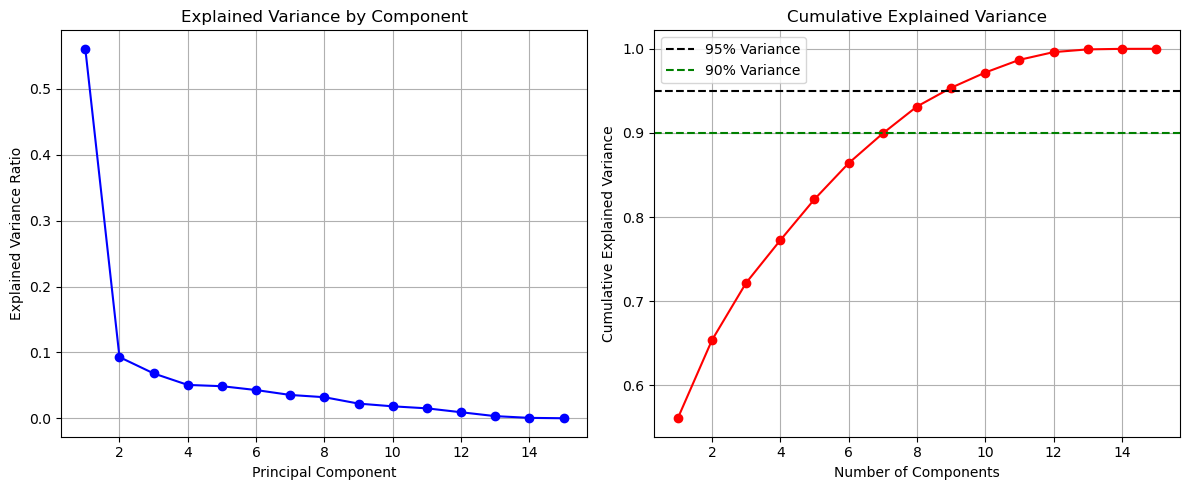

PCA Analysis:
Explained variance ratio by component:
PC1: 0.5609 (56.09%)
PC2: 0.0929 (9.29%)
PC3: 0.0681 (6.81%)
PC4: 0.0506 (5.06%)
PC5: 0.0487 (4.87%)
PC6: 0.0428 (4.28%)
PC7: 0.0354 (3.54%)
PC8: 0.0320 (3.20%)
PC9: 0.0223 (2.23%)
PC10: 0.0181 (1.81%)
PC11: 0.0151 (1.51%)
PC12: 0.0092 (0.92%)
PC13: 0.0033 (0.33%)
PC14: 0.0006 (0.06%)
PC15: 0.0000 (0.00%)

Cumulative explained variance:
PC1-PC1: 0.5609 (56.09%)
PC1-PC2: 0.6537 (65.37%)
PC1-PC3: 0.7218 (72.18%)
PC1-PC4: 0.7725 (77.25%)
PC1-PC5: 0.8212 (82.12%)
PC1-PC6: 0.8640 (86.40%)
PC1-PC7: 0.8994 (89.94%)
PC1-PC8: 0.9314 (93.14%)
PC1-PC9: 0.9537 (95.37%)
PC1-PC10: 0.9718 (97.18%)
PC1-PC11: 0.9869 (98.69%)
PC1-PC12: 0.9961 (99.61%)
PC1-PC13: 0.9993 (99.93%)
PC1-PC14: 1.0000 (100.00%)
PC1-PC15: 1.0000 (100.00%)

Components needed for 90% variance: 8
Components needed for 95% variance: 9


In [13]:
# Customer clustering with PCA


# Prepare data for clustering
# Select numerical features for clustering (excluding customer identifiers)
clustering_features = ['doc_no_unique', 'frequency_q', 'big_order_count', 'material_name_unique', 'log_monetary', 'log_recency', 
'Accessories', 'Carbomix', 'HIC', 'IEX', 'RP', 'SEC', 'Sepax Protein Standard', 'Service', 'Tween']


num_cols = ['doc_no_unique', 'frequency_q', 'material_name_unique', 'log_monetary', 'log_recency', 
'Accessories', 'Carbomix', 'HIC', 'IEX', 'RP', 'SEC', 'Sepax Protein Standard', 'Service', 'Tween']
['monetary', 'doc_no_unique', 'frequency_q', 'material_name_unique', 
                      'log_monetary', 'log_recency', 'Accessories', 'Carbomix', 'IEX', 
                      'RP', 'SEC', 'Service', 'Sepax Protein Standard', 'Tween']
# Create clustering dataset
X = active_customers[clustering_features].copy()

# Handle missing values if any
X = X.fillna(0)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
# First, analyze explained variance to determine optimal number of components
pca_full = PCA()
pca_full.fit(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')
plt.grid(True)

plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.axhline(y=0.95, color='k', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print explained variance details
print("PCA Analysis:")
print("Explained variance ratio by component:")
for i, var_ratio in enumerate(pca_full.explained_variance_ratio_):
    print(f"PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")

print(f"\nCumulative explained variance:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1-PC{i+1}: {cum_var:.4f} ({cum_var*100:.2f}%)")

# Determine number of components for 90% and 95% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")


###  K-Means Clustering


Applying PCA with 8 components
Original features: 15
PCA features: 8
Variance explained: 0.9314 (93.14%)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

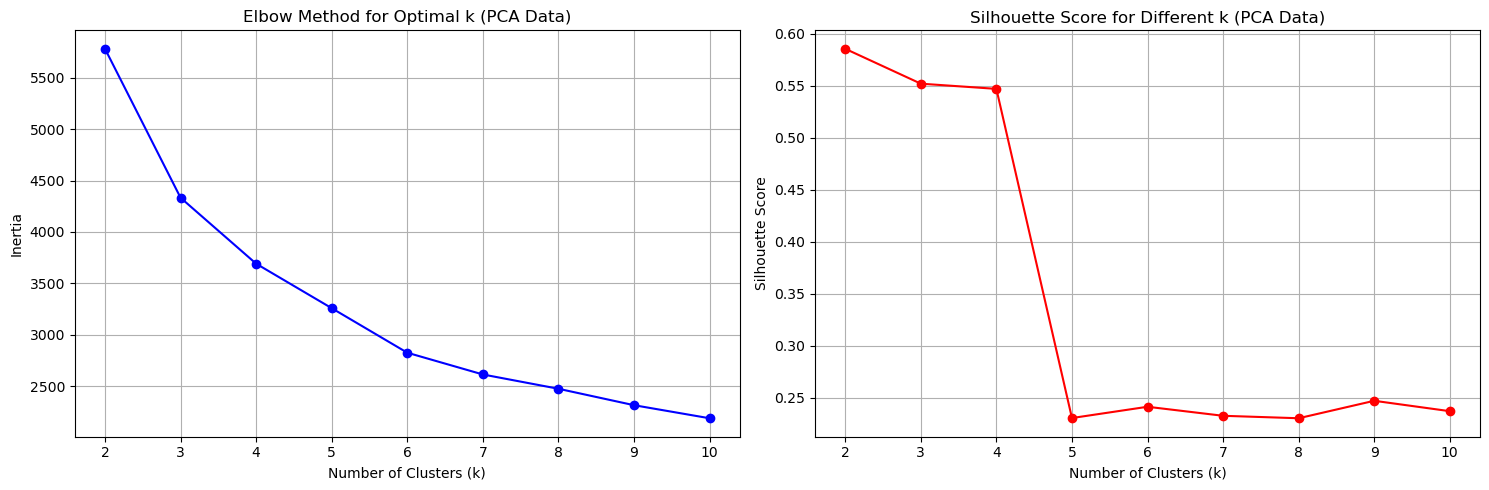

K-means clustering metrics on PCA data:
k	Inertia		Silhouette Score
-----------------------------------
2	5779.81		0.585
3	4332.42		0.552
4	3691.55		0.547
5	3259.34		0.230
6	2826.65		0.241
7	2615.23		0.233
8	2476.32		0.230
9	2316.65		0.247
10	2189.71		0.237


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



Clustering results with k=6 (PCA data):
Silhouette score: 0.241

Cluster distribution:
kmeans_cluster
0    271
1     14
2    117
3    300
4      5
5      6
Name: count, dtype: int64

Cluster characteristics (mean values in original features):
                doc_no_unique  frequency_q  big_order_count  \
kmeans_cluster                                                
0                        3.66         2.58             0.10   
1                       91.43         9.57            17.86   
2                       31.81         7.44             3.53   
3                        6.04         3.95             0.28   
4                       42.40         8.00             5.20   
5                      131.33         9.83            34.83   

                material_name_unique  log_monetary  log_recency  Accessories  \
kmeans_cluster                                                                 
0                               3.57          8.65         5.08         0.34   
1          

In [14]:
# Apply PCA with optimal number of components (95% variance)
pca = PCA(n_components=n_components_90)
X_pca = pca.fit_transform(X_scaled)

print(f"\nApplying PCA with {n_components_90} components")
print(f"Original features: {X_scaled.shape[1]}")
print(f"PCA features: {X_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# Determine optimal number of clusters using elbow method on PCA data
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot elbow curve and silhouette scores for PCA data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k (PCA Data)')
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k (PCA Data)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Display metrics for manual selection
print("K-means clustering metrics on PCA data:")
print("k\tInertia\t\tSilhouette Score")
print("-" * 35)
for i, k in enumerate(k_range):
    print(f"{k}\t{inertias[i]:.2f}\t\t{silhouette_scores[i]:.3f}")

# Manual k selection - change this value as needed
# We select the optimal k based on business needs although it may not have a good score but explain business better

manual_k = 6  

# Perform clustering with manually selected k on PCA data
kmeans_final = KMeans(n_clusters=manual_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca)

# Add cluster labels to the dataframe
active_customers_clustered = active_customers.copy()
active_customers_clustered['kmeans_cluster'] = cluster_labels

# Display cluster statistics
print(f"\nClustering results with k={manual_k} (PCA data):")
print(f"Silhouette score: {silhouette_score(X_pca, cluster_labels):.3f}")
print(f"\nCluster distribution:")
print(active_customers_clustered['kmeans_cluster'].value_counts().sort_index())

# Calculate cluster centroids in original scale
cluster_summary = active_customers_clustered.groupby('kmeans_cluster')[clustering_features].mean()
print(f"\nCluster characteristics (mean values in original features):")
print(cluster_summary.round(2))

# PCA component interpretation
print(f"\nPCA Component Analysis:")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_90)],
    index=clustering_features
)
print("Feature loadings on principal components:")
print(components_df.round(3))




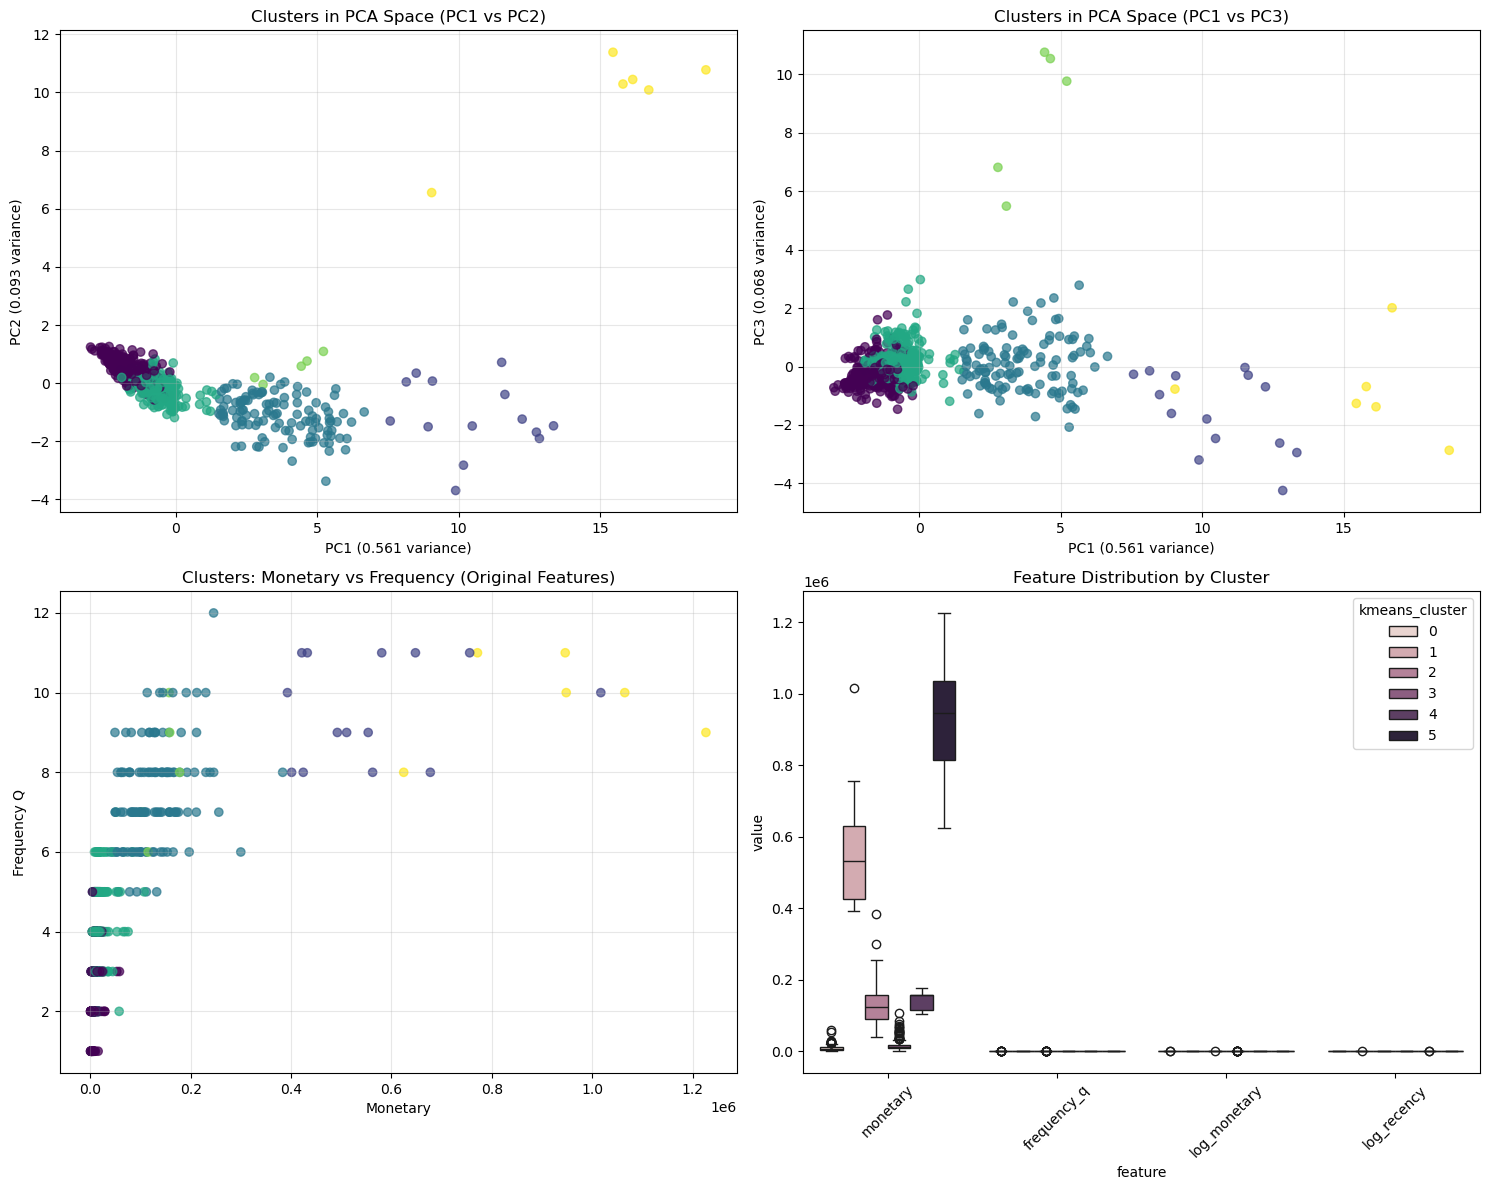

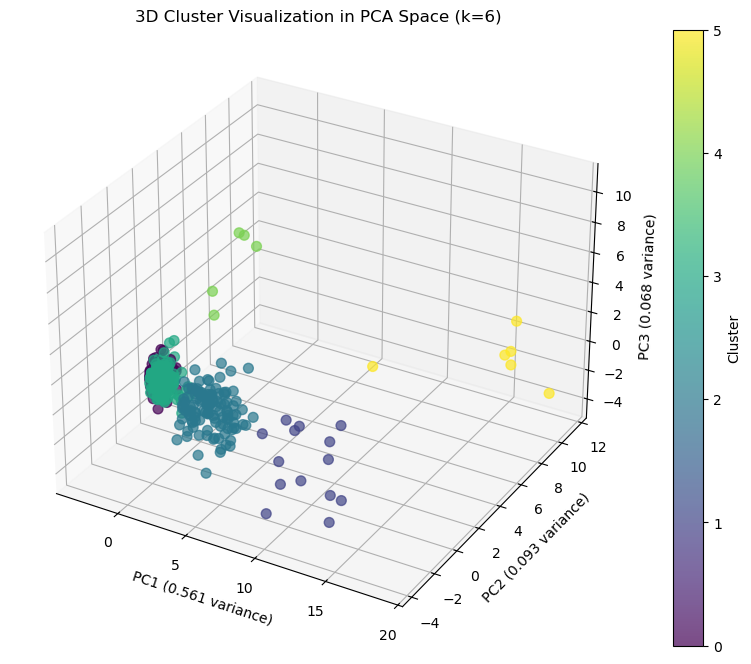

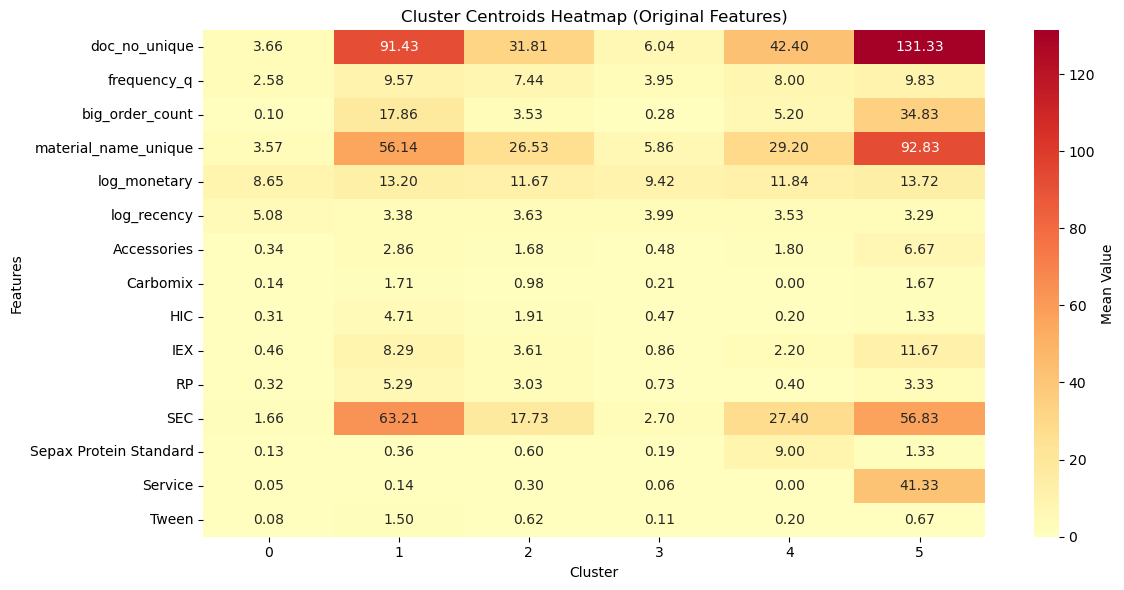

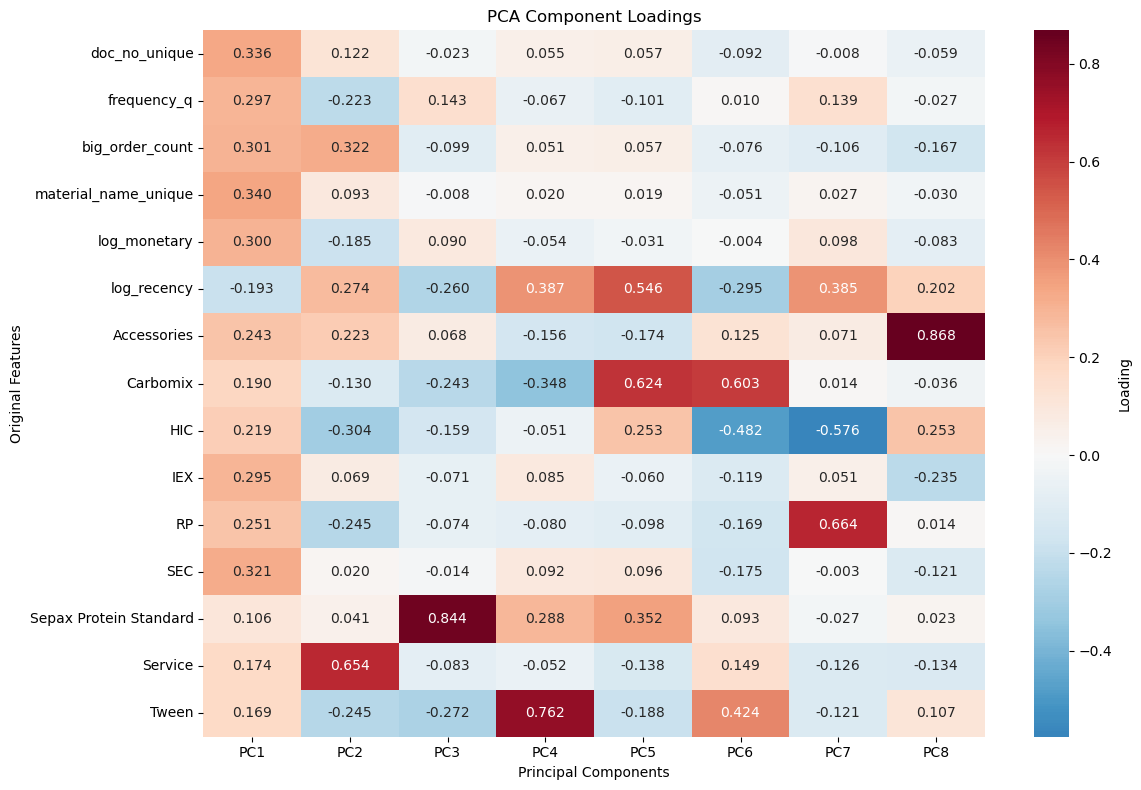

In [15]:
# Visualize clustering results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Scatter plot in PCA space (PC1 vs PC2) colored by cluster
if n_components_95 >= 2:
    axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=active_customers_clustered['kmeans_cluster'], cmap='viridis', alpha=0.7)
    axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
    axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
    axes[0, 0].set_title('Clusters in PCA Space (PC1 vs PC2)')
    axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot in PCA space (PC1 vs PC3) colored by cluster
if n_components_95 >= 3:
    axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 2], 
                       c=active_customers_clustered['kmeans_cluster'], cmap='viridis', alpha=0.7)
    axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
    axes[0, 1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.3f} variance)')
    axes[0, 1].set_title('Clusters in PCA Space (PC1 vs PC3)')
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'PC3 not available', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('PC3 not available')

# Plot 3: Original feature space - monetary vs frequency_q colored by cluster
axes[1, 0].scatter(active_customers_clustered['monetary'], active_customers_clustered['frequency_q'], 
                   c=active_customers_clustered['kmeans_cluster'], cmap='viridis', alpha=0.7)
axes[1, 0].set_xlabel('Monetary')
axes[1, 0].set_ylabel('Frequency Q')
axes[1, 0].set_title('Clusters: Monetary vs Frequency (Original Features)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Box plot showing cluster distribution across key original features
cluster_melted = active_customers_clustered[['kmeans_cluster', 'monetary', 'frequency_q', 'log_monetary', 'log_recency']].melt(
    id_vars=['kmeans_cluster'], var_name='feature', value_name='value')

sns.boxplot(data=cluster_melted, x='feature', y='value', hue='kmeans_cluster', ax=axes[1, 1])
axes[1, 1].set_title('Feature Distribution by Cluster')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Additional visualization: 3D scatter plot in PCA space
if n_components_95 >= 3:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create 3D scatter plot using first 3 principal components
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                        c=active_customers_clustered['kmeans_cluster'], 
                        cmap='viridis', 
                        alpha=0.7, 
                        s=50)

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.3f} variance)')
    ax.set_title(f'3D Cluster Visualization in PCA Space (k={manual_k})')

    # Add colorbar
    plt.colorbar(scatter, label='Cluster')
    plt.show()

# Heatmap of cluster centroids in original feature space
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.T, annot=True, cmap='RdYlBu_r', center=0, 
            cbar_kws={'label': 'Mean Value'}, fmt='.2f')
plt.title('Cluster Centroids Heatmap (Original Features)')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Additional: Show PCA component loadings heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(components_df, annot=True, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Loading'}, fmt='.3f')
plt.title('PCA Component Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.tight_layout()
plt.show()


## Hierarchical Clustering Analysis
This section applies hierarchical clustering as an alternative approach to segment customers, which can reveal nested group structures that K-means might not capture.


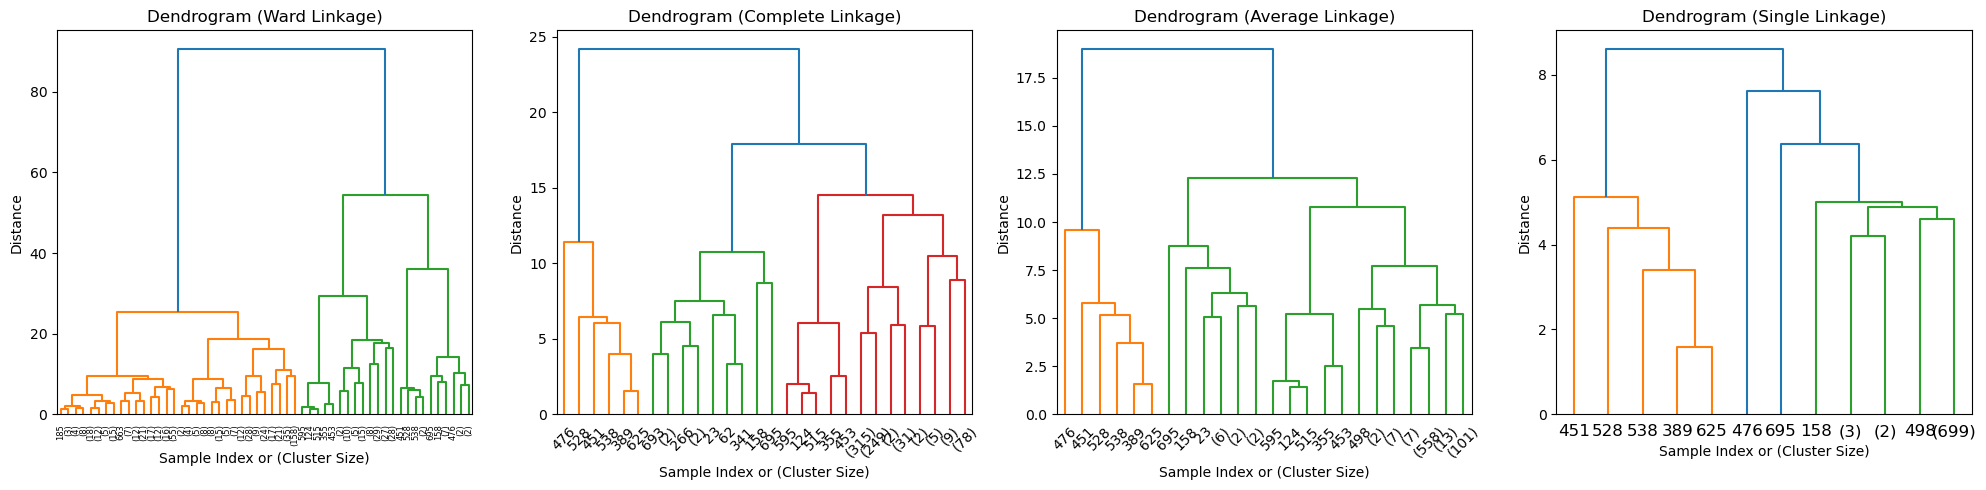

Hierarchical Clustering Results:
Number of clusters: 6

Hierarchical cluster distribution:
1    207
2    358
3      5
4    124
5      5
6     14
Name: count, dtype: int64

Hierarchical Cluster Summary:
                     doc_no_unique                  frequency_q            \
                              mean        std count        mean       std   
hierarchical_cluster                                                        
1                         3.246377   1.727048   207    2.439614  0.967920   
2                         5.650838   1.879683   358    3.751397  1.054368   
3                        42.400000   9.939819     5    8.000000  1.581139   
4                        31.491935  10.366845   124    7.362903  1.339425   
5                       141.000000  10.000000     5   10.200000  0.836660   
6                        91.928571  15.389628    14    9.500000  1.344504   

                           big_order_count                  \
                     count            mean

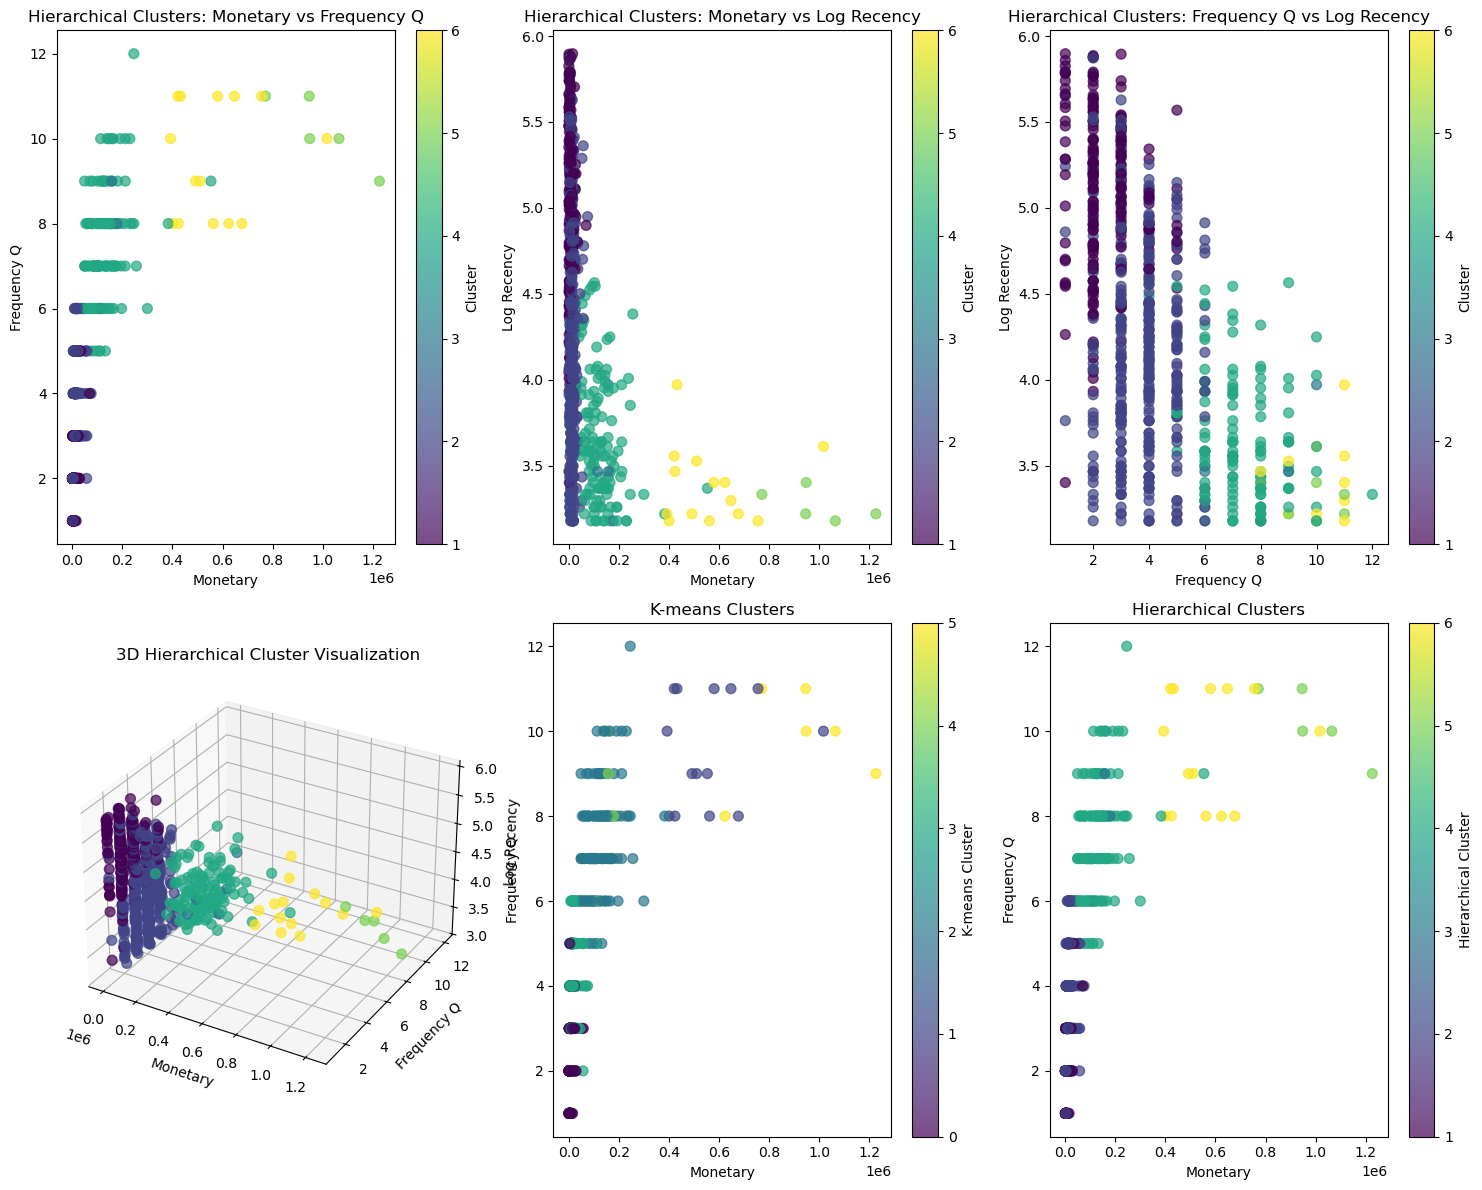

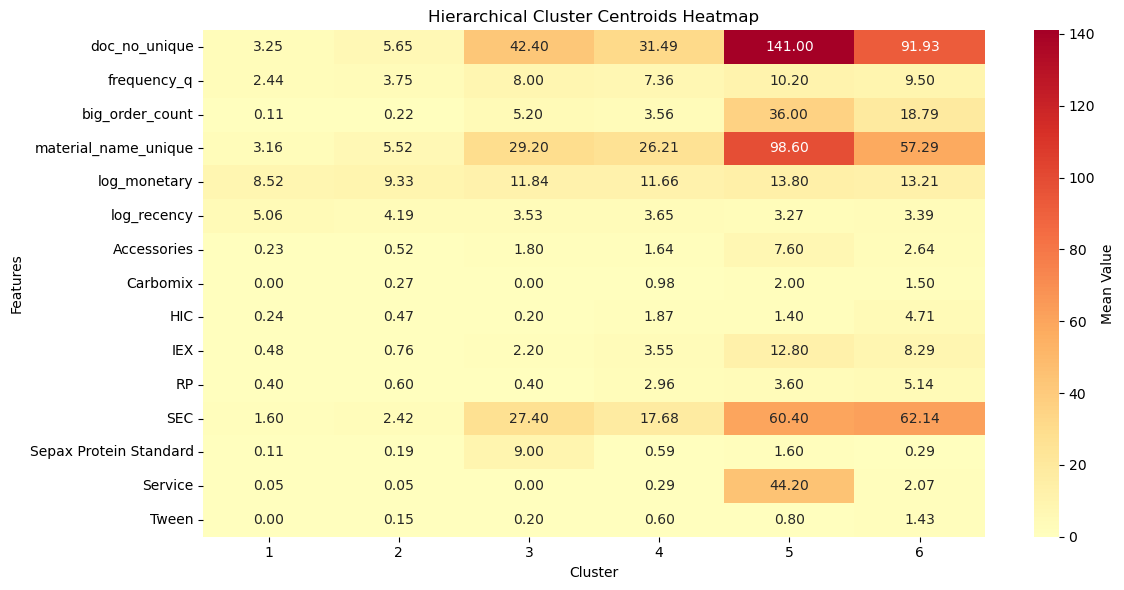


Clustering Method Comparison:
Adjusted Rand Score: 0.611
Normalized Mutual Information: 0.688

Cross-tabulation of K-means vs Hierarchical clusters:
hierarchical_cluster    1    2  3    4  5   6  All
kmeans_cluster                                    
0                     194   77  0    0  0   0  271
1                       0    0  0    1  0  13   14
2                       0    0  0  117  0   0  117
3                      13  281  0    6  0   0  300
4                       0    0  5    0  0   0    5
5                       0    0  0    0  5   1    6
All                   207  358  5  124  5  14  713


In [16]:
# Hierarchical Clustering Analysis
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Prepare the data for hierarchical clustering (same as K-means)
#features_for_clustering = ['monetary', 'frequency_q', 'log_recency']
#X_hierarchical = active_customers[features_for_clustering].values

# Standardize the features

# scaler_hierarchical = StandardScaler()
# X_hierarchical_scaled = scaler_hierarchical.fit_transform(X_hierarchical)

# Compute the linkage matrix using different methods
linkage_methods = ['ward', 'complete', 'average', 'single']
plt.figure(figsize=(20, 5))

for i, method in enumerate(linkage_methods):
    plt.subplot(1, 4, i+1)
    linkage_matrix = linkage(X_pca, method=method)
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title(f'Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Sample Index or (Cluster Size)')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

# Use Ward linkage for final clustering (generally works well)   This is reduntant step - so i deleted it
linkage_matrix = linkage(X_pca, method='ward')



# Determine optimal number of clusters by looking at the dendrogram
# or using a distance threshold
n_clusters_hierarchical = 6  # Based on dendrogram observation, adjust as needed

# Get cluster labels
hierarchical_labels = fcluster(linkage_matrix, n_clusters_hierarchical, criterion='maxclust')

# Add hierarchical cluster labels to the dataframe
active_customers_hierarchical = active_customers.copy()
active_customers_hierarchical['hierarchical_cluster'] = hierarchical_labels

# Compare with K-means clusters
active_customers_hierarchical['kmeans_cluster'] = active_customers_clustered['kmeans_cluster']

print("Hierarchical Clustering Results:")
print(f"Number of clusters: {n_clusters_hierarchical}")
print("\nHierarchical cluster distribution:")
print(pd.Series(hierarchical_labels).value_counts().sort_index())

# Calculate cluster statistics for hierarchical clustering
hierarchical_summary = active_customers_hierarchical.groupby('hierarchical_cluster')[clustering_features].agg(['mean', 'std', 'count'])
print("\nHierarchical Cluster Summary:")
print(hierarchical_summary)

# Visualize hierarchical clusters
fig = plt.figure(figsize=(15, 12))

# 2D scatter plots
subplot_configs = [
    ('monetary', 'frequency_q', 1),
    ('monetary', 'log_recency', 2),
    ('frequency_q', 'log_recency', 3)
]

for x_col, y_col, subplot_idx in subplot_configs:
    plt.subplot(2, 3, subplot_idx)
    scatter = plt.scatter(active_customers_hierarchical[x_col], 
                         active_customers_hierarchical[y_col],
                         c=active_customers_hierarchical['hierarchical_cluster'], 
                         cmap='viridis', 
                         alpha=0.7, 
                         s=50)
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(y_col.replace('_', ' ').title())
    plt.title(f'Hierarchical Clusters: {x_col.replace("_", " ").title()} vs {y_col.replace("_", " ").title()}')
    plt.colorbar(scatter, label='Cluster')

# 3D visualization
ax = fig.add_subplot(2, 3, 4, projection='3d')
scatter = ax.scatter(active_customers_hierarchical['monetary'],
                    active_customers_hierarchical['frequency_q'],
                    active_customers_hierarchical['log_recency'],
                    c=active_customers_hierarchical['hierarchical_cluster'], 
                    cmap='viridis', 
                    alpha=0.7, 
                    s=50)

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency Q')
ax.set_zlabel('Log Recency')
ax.set_title(f'3D Hierarchical Cluster Visualization')

# Comparison of clustering methods
plt.subplot(2, 3, 5)
scatter = plt.scatter(active_customers_hierarchical['monetary'], 
                     active_customers_hierarchical['frequency_q'],
                     c=active_customers_hierarchical['kmeans_cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=50)
plt.xlabel('Monetary')
plt.ylabel('Frequency Q')
plt.title('K-means Clusters')
plt.colorbar(scatter, label='K-means Cluster')

plt.subplot(2, 3, 6)
scatter = plt.scatter(active_customers_hierarchical['monetary'], 
                     active_customers_hierarchical['frequency_q'],
                     c=active_customers_hierarchical['hierarchical_cluster'], 
                     cmap='viridis', 
                     alpha=0.7, 
                     s=50)
plt.xlabel('Monetary')
plt.ylabel('Frequency Q')
plt.title('Hierarchical Clusters')
plt.colorbar(scatter, label='Hierarchical Cluster')

plt.tight_layout()
plt.show()

# Heatmap of hierarchical cluster centroids
hierarchical_centroids = active_customers_hierarchical.groupby('hierarchical_cluster')[clustering_features].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(hierarchical_centroids.T, annot=True, cmap='RdYlBu_r', center=0, 
            cbar_kws={'label': 'Mean Value'}, fmt='.2f')
plt.title('Hierarchical Cluster Centroids Heatmap')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Compare clustering methods - confusion matrix style
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("\nClustering Method Comparison:")
print(f"Adjusted Rand Score: {adjusted_rand_score(active_customers_hierarchical['kmeans_cluster'], active_customers_hierarchical['hierarchical_cluster']):.3f}")
print(f"Normalized Mutual Information: {normalized_mutual_info_score(active_customers_hierarchical['kmeans_cluster'], active_customers_hierarchical['hierarchical_cluster']):.3f}")

# Cross-tabulation of cluster assignments
print("\nCross-tabulation of K-means vs Hierarchical clusters:")
crosstab = pd.crosstab(active_customers_hierarchical['kmeans_cluster'], 
                       active_customers_hierarchical['hierarchical_cluster'], 
                       margins=True)
print(crosstab)


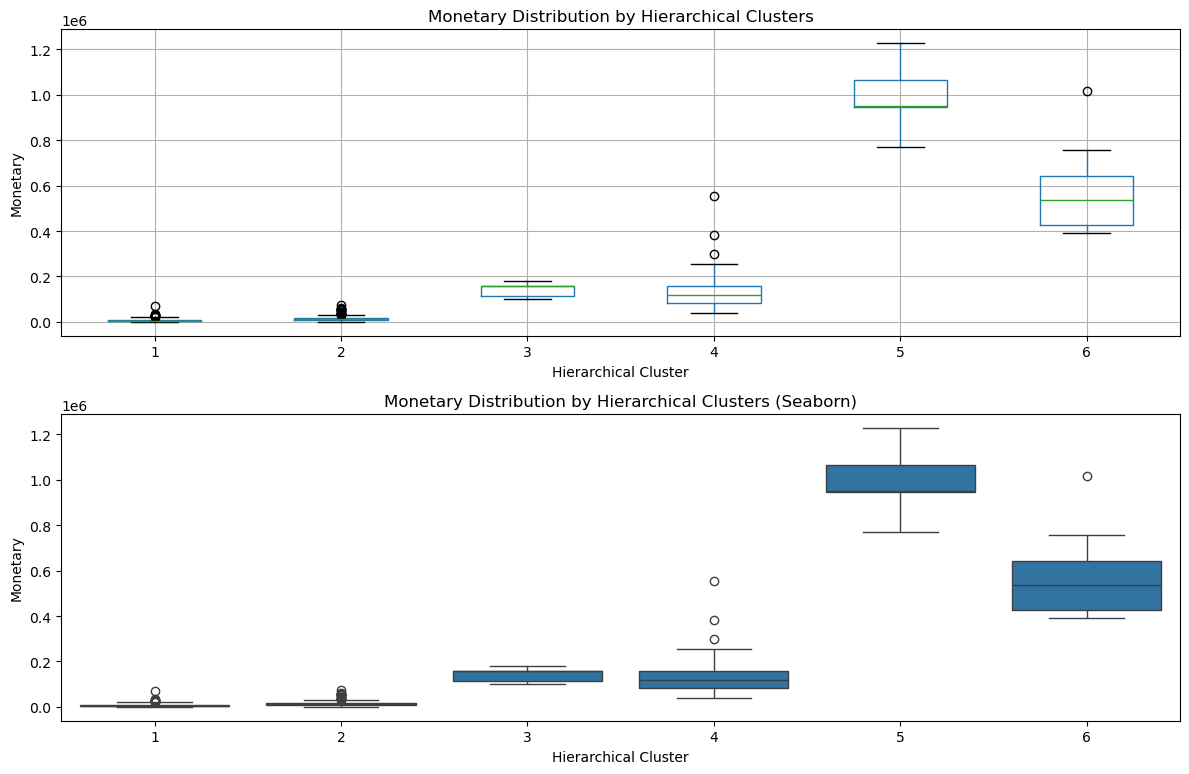

In [17]:
# Box plot for monetary values by hierarchical clusters
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
active_customers_hierarchical.boxplot(column='monetary', by='hierarchical_cluster', ax=plt.gca())
plt.title('Monetary Distribution by Hierarchical Clusters')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Monetary')
plt.suptitle('')  # Remove the automatic title

# Alternative using seaborn for better styling
plt.subplot(2, 1, 2)
sns.boxplot(data=active_customers_hierarchical, x='hierarchical_cluster', y='monetary')
plt.title('Monetary Distribution by Hierarchical Clusters (Seaborn)')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Monetary')

plt.tight_layout()
plt.show()


## Customer Clustering Results

### Returning Customer Dataframe

In [18]:
# Add cluster labels to active_customers
active_customers['kmeans_cluster'] = active_customers_clustered['kmeans_cluster']

# Display first few rows to verify the cluster assignment
print("Customer data with cluster labels:")
print(active_customers[['customer_group', 'assigned_rep', 'churn', 'monetary', 'frequency_q', 'log_recency', 'kmeans_cluster']].head(10))

# Show cluster distribution
print("\nCluster distribution:")
print(active_customers['kmeans_cluster'].value_counts().sort_index())


Customer data with cluster labels:
   customer_group assigned_rep  churn   monetary  frequency_q  log_recency  \
0       ACCT_0001  Sales Rep H      0   51687.68            7     4.276666   
1       ACCT_0002  Sales Rep A      0   15094.03            3     4.043051   
2       ACCT_0003  Sales Rep A      0   14780.37            4     4.189655   
4       ACCT_0005  Sales Rep H      0    5059.60            4     5.283204   
5       ACCT_0006  Sales Rep G      0   60984.63            8     3.637586   
6       ACCT_0007  Sales Rep B      0   12941.28            4     4.912655   
7       ACCT_0008  Sales Rep G      0    8355.25            2     3.401197   
8       ACCT_0009  Sales Rep E      0    1658.79            1     5.583496   
9       ACCT_0010  Sales Rep E      0  100221.43            6     3.258097   
10      ACCT_0011  Sales Rep D      0   21433.17            5     4.465908   

    kmeans_cluster  
0                3  
1                3  
2                3  
4                0  
5

C:\Users\User\AppData\Local\Temp\ipykernel_58904\469305113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers['kmeans_cluster'] = active_customers_clustered['kmeans_cluster']


In [19]:
# Add cluster assignments to customer_df as well
active_customers['hierarchical_cluster'] = active_customers_hierarchical['hierarchical_cluster'].values

print("Cluster assignments added to active_customers")
print(f"active_customers shape: {active_customers.shape}")
print("\nSample of active_customers with cluster assignments:")
print(active_customers[['customer_group', 'monetary', 'frequency_q', 'kmeans_cluster', 'hierarchical_cluster']].head())


Cluster assignments added to active_customers
active_customers shape: (713, 32)

Sample of active_customers with cluster assignments:
  customer_group  monetary  frequency_q  kmeans_cluster  hierarchical_cluster
0      ACCT_0001  51687.68            7               3                     4
1      ACCT_0002  15094.03            3               3                     2
2      ACCT_0003  14780.37            4               3                     2
4      ACCT_0005   5059.60            4               0                     1
5      ACCT_0006  60984.63            8               2                     4


C:\Users\User\AppData\Local\Temp\ipykernel_58904\178371149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers['hierarchical_cluster'] = active_customers_hierarchical['hierarchical_cluster'].values


In [20]:
# Calculate cluster centroids in original scale

kmeans_cluster_summary = active_customers_hierarchical.groupby('kmeans_cluster')[clustering_features].mean()
print("\nK-means Cluster counts:")
print(active_customers_hierarchical['kmeans_cluster'].value_counts().sort_index())
print(f"\nK-means Cluster characteristics (mean values in original features):")
print(kmeans_cluster_summary.round(2))

hierarchical_cluster_summary = active_customers_hierarchical.groupby('hierarchical_cluster')[clustering_features].mean()
print("\nHierarchical Cluster counts:")
print(active_customers_hierarchical['hierarchical_cluster'].value_counts().sort_index())
print(f"\nHierarchical Cluster characteristics (mean values in original features):")
print(hierarchical_cluster_summary.round(2))



K-means Cluster counts:
kmeans_cluster
0    271
1     14
2    117
3    300
4      5
5      6
Name: count, dtype: int64

K-means Cluster characteristics (mean values in original features):
                doc_no_unique  frequency_q  big_order_count  \
kmeans_cluster                                                
0                        3.66         2.58             0.10   
1                       91.43         9.57            17.86   
2                       31.81         7.44             3.53   
3                        6.04         3.95             0.28   
4                       42.40         8.00             5.20   
5                      131.33         9.83            34.83   

                material_name_unique  log_monetary  log_recency  Accessories  \
kmeans_cluster                                                                 
0                               3.57          8.65         5.08         0.34   
1                              56.14         13.20         3.38   

In [21]:
churn_df = customer_df[customer_df['churn'] == 1]
customer_df = pd.concat([active_customers, churn_df], ignore_index=True).fillna(-1)

In [22]:
from pandas import ExcelWriter

# write a excel file with each cluster as a sheet
with ExcelWriter('customer_analysis_by_cluster_simulated.xlsx') as writer:

    numeric_columns = customer_df.select_dtypes(include=['number']).columns
    cluster_summary = customer_df.groupby('kmeans_cluster')[numeric_columns].mean().round(2)
    cluster_summary.to_excel(writer, sheet_name='Cluster_Summary', index=True)

    # check clusters
    for cluster in sorted(customer_df['kmeans_cluster'].unique()):
        cluster_data = customer_df[customer_df['kmeans_cluster'] == cluster]
        sheet_name = f'Cluster_{cluster}'
        cluster_data.to_excel(writer, sheet_name=sheet_name, index=False)
    
    
    customer_df.to_excel(writer, sheet_name='All_Customers', index=False)
    
